In [1]:
import pandas as pd
import pymysql
import getpass

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [3]:
conn = pymysql.connect(host="35.233.174.193",port=3306,
                       user="jovyan",passwd=getpass.getpass("Enter password for MIMIC2 database"),
                       db='mimic2')

Enter password for MIMIC2 database········


# Labs
Lab tests are used for diagnostic purposes.

In [4]:
query = """
select labevents.subject_id, labevents.hadm_id as 'hospital_admission_id',
    labevents.charttime as 'datetime',
    labevents.value, labevents.flag,
    labevents.valueuom as 'units',
    d_labitems.test_name,
    d_labitems.fluid,
    d_labitems.category,
    d_labitems.loinc_code,
    d_labitems.loinc_description
from labevents
    inner join d_labitems
    on labevents.itemid = d_labitems.itemid
where loinc_code = '2345-7'
limit 10
"""
df = pd.read_sql(query, conn)
df.head()

,subject_id,hospital_admission_id,datetime,value,flag,units,test_name,fluid,category,loinc_code,loinc_description
0,56,28766.0,2644-01-17 00:30:00,155,abnormal,mg/dL,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
1,56,28766.0,2644-01-17 03:57:00,146,abnormal,mg/dL,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
2,56,28766.0,2644-01-18 03:30:00,140,abnormal,mg/dL,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
3,56,28766.0,2644-01-19 12:40:00,108,abnormal,mg/dL,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
4,37,18052.0,3264-08-14 06:00:00,303,abnormal,mg/dL,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma


The purpose of a lab test is given by its LOINC code. LOINC is a standardized terminology for lab tests, similar to what ICD-9/10 codes are for diagnoses. 

### TODO
Let's find all LOINC codes that contain "Cholesterol" in the title. We can use the `"like %x%"` statement in SQL to find texts which contain a certain string. Change the query below to filter for loinc codes where the description contains the text "cholesterol".

In [ ]:
query = """
select loinc_code, loinc_description
from d_labitems
where ___ like '%___%' 
"""
df = pd.read_sql(query, conn)
df.head()

Let's focus on a specific lab test. We'll look at the LOINC code 2345-7, which measures the amount of glucose in a patient's blood. This test is relevant for testing whether a patient has diabetes.


In [5]:
query = """
select *
from labevents
    inner join d_labitems
    on labevents.itemid = d_labitems.itemid
where loinc_code = '2345-7'
limit 1000
"""
df = pd.read_sql(query, conn)
df.head()

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valuenum,flag,valueuom,itemid,test_name,fluid,category,loinc_code,loinc_description
0,56,28766.0,NaN,50112,2644-01-17 00:30:00,155,155.0,abnormal,mg/dL,50112,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
1,56,28766.0,62.0,50112,2644-01-17 03:57:00,146,146.0,abnormal,mg/dL,50112,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
2,56,28766.0,62.0,50112,2644-01-18 03:30:00,140,140.0,abnormal,mg/dL,50112,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
3,56,28766.0,NaN,50112,2644-01-19 12:40:00,108,108.0,abnormal,mg/dL,50112,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma
4,37,18052.0,NaN,50112,3264-08-14 06:00:00,303,303.0,abnormal,mg/dL,50112,GLUCOSE,BLOOD,CHEMISTRY,2345-7,Glucose [Mass/volume] in Serum or Plasma


Note the column **flag**. This is a string value which tells whether a test is abnormal. Let's see how many of the 1000 labs we retrieved are abnormal. To do this, we can call the `value_counts` method of the column in the dataframe:

In [6]:
df['flag'].value_counts()

abnormal    698
Name: flag, dtype: int64

Why are only "abnormal" tests showing up?

**TODO:** Change the `value_counts` method to show null values by adding a keyword argument `dropna=False`

In [7]:
df['flag'].value_counts(___)

abnormal    698
NaN         302
Name: flag, dtype: int64

In addition, we can fill these null values in our SQL query by using the `coalesce` function. This will take the first non-null value in a list. So, for example,

`coalesce(null, 'world!')` would return 'world!', while `coalesce('hello,', null)` would return 'hello'.

**TODO:** Change the query below so that SQL will return the value of the column `flag` if it is not null and will return `'normal'` otherwise.

In [8]:
query = """
select labevents.subject_id,
    hadm_id,
   valuenum,
    coalesce(flag, ___) as 'flag',
    labevents.valueuom as 'units',
    d_labitems.test_name,
    d_labitems.loinc_code,
    d_labitems.loinc_description
from labevents
    inner join d_labitems
    on labevents.itemid = d_labitems.itemid
where loinc_code = '2345-7'
limit 1000
"""
df = pd.read_sql(query, conn)
df.head()

,subject_id,hadm_id,valuenum,flag,units,test_name,loinc_code,loinc_description
0,56,28766.0,155.0,abnormal,mg/dL,GLUCOSE,2345-7,Glucose [Mass/volume] in Serum or Plasma
1,56,28766.0,146.0,abnormal,mg/dL,GLUCOSE,2345-7,Glucose [Mass/volume] in Serum or Plasma
2,56,28766.0,140.0,abnormal,mg/dL,GLUCOSE,2345-7,Glucose [Mass/volume] in Serum or Plasma
3,56,28766.0,108.0,abnormal,mg/dL,GLUCOSE,2345-7,Glucose [Mass/volume] in Serum or Plasma
4,37,18052.0,303.0,abnormal,mg/dL,GLUCOSE,2345-7,Glucose [Mass/volume] in Serum or Plasma


In [9]:
df['flag'].value_counts(dropna=False)

abnormal    698
normal      302
Name: flag, dtype: int64

### TODO
Create two plots:
1. Generate a histogram of the `flag` column of df
2. Generate a boxplot of the `valuenum` column stratified by flag (**hint:** remember when we stratified patient age of death by gender?)

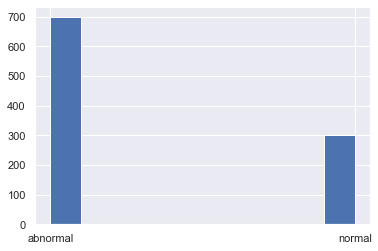

In [10]:
df['flag'].___()

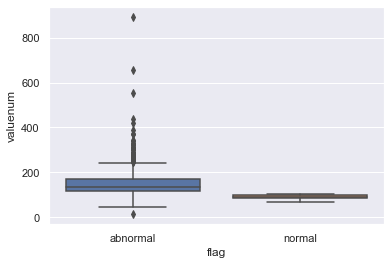

In [11]:
ax = sns.boxplot(x=___, y=___, data=df, order=['abnormal', 'normal'])

### Discussion 
Do you think it's unusual that this test shows more "abnormal" results than "normal"? Why do you think that is?

## Aggregate functions
Note that the tests above have multiple values for the same patient taken a few hours apart. It might be useful to group together all of the values for a single patient and perform operations on all of a patient's values. Let's use aggregate functions to determine the min, max, and average values for a patient during one hospital stay.

### TODO
Write a query which retrieves lab results for the LOINC code '2345-7' and groups the results together by **subject_id**. Calculate the minimum, maximum, and average values for each patient and name them 'min_value', 'max_value', and 'avg_value'.

In [ ]:
query = """
select labevents.subject_id,
    min(valuenum) as '___',
    ___(valuenum) as 'max_value',
    ___(valuenum) as '___'
from labevents
    inner join d_labitems
    on labevents.itemid = d_labitems.itemid
where loinc_code = '2345-7'
group by ___
limit 100
"""
df = pd.read_sql(query, conn)
df.head()

### Bonus
Plot the 'avg_value' column from the dataframe above.

# Chart Events
The `chartevents` table in MIMIC-II contains vitals measurements. The table `d_chartitems` defines what these measurements. Let's look at what the first 25 alphabetical vital measurements are:

In [ ]:
query = """
select distinct d_chartitems.label
 from d_chartitems
limit 25;
"""
df = pd.read_sql(query, conn)
df.head(25)

Now let's query the first 1000 rows from `chartevents` to see what some actual measurements look like:

In [ ]:
query = """
select
    *
 from mimic2.chartevents
inner join d_chartitems on chartevents.itemid = d_chartitems.itemid
limit 1000;
"""
df = pd.read_sql(query, conn)
df.head()

In [ ]:
df['label'].value_counts()

Let's look at some measurements for blood pressure. I checked beforehand and found 4 tests which we could use. Their id's in `d_chartitems` are (6, 51, 455, 6701). Let's look at what these tests are:

In [ ]:
# Blood pressure
query = """
select
    *
 from d_chartitems
where itemid in (6, 51, 455, 6701);
"""
df = pd.read_sql(query, conn)
df.head()

Again, let's query `chartevents` to see what these measurements actually look like:

In [ ]:
# Blood pressure
query = """
select
    *
 from mimic2.chartevents
    inner join d_chartitems on chartevents.itemid = d_chartitems.itemid
where d_chartitems.itemid in (6, 51, 455, 6701)
limit 5;
"""
df = pd.read_sql(query, conn)
df.head()

The values which we're interested in here are:
- `"value1num"` - this represents the systolic blood pressure
- `"value2num"` - this represents the diastolic blood pressure

### TODO
Write a query for these blood pressure measurements and assign aliases to these two values:
- `"value1num"` should be called "systolic_bp"
- `"value2num"` should be called "diastolic_bp"

In [ ]:
# Blood pressure
query = """
select
    subject_id, icustay_id, charttime, 
    value1num as '___',
    ___ as '___',
    label
 from mimic2.chartevents
    inner join d_chartitems on chartevents.itemid = d_chartitems.itemid
where d_chartitems.itemid in ___
limit 1000;
"""
df = pd.read_sql(query, conn)

In [ ]:
df.head(10)

### Discussion
Some measurements are 0. Others are null. What do you think this means? What should we do with these rows?


In [ ]:
df = df[df['systolic_bp'] > 0]
df = df.dropna()

In [ ]:
df.head()

## Plotting Vitals
Now, let's plot these variables.

### TODO
Plot the distribution of systolic and diastolic blood pressures side-by-side. I've created two subplots next to each other. Call the `hist` method on the appropriate columns of the DataFrame.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
df[___].hist(ax=ax1)
df['diastolic_bp'].___(ax=ax2)

Let's look at how these two readings are **correlated** with one another. We can do this in two ways. First, we'll plot a **scatterplot** which will allow us to visualize the relationship between one variable (systolic blood pressure) and another (diastolic). Next, we can calculate the correlation coefficient of the two variables by using the `corr` method of the columns in the dataframe.

In [ ]:
df.head()

### TODO
Call the function `sns.scatterplot`. Plot 'diastolic_bp' on the x axis and 'systolic_bp' on the y axis.

In [ ]:
___.___(x=___, y=___, data=df)

In [ ]:
df['diastolic_bp'].corr(df['systolic_bp'])

### Discussion
Look at the scatterplot of the two blood pressure readings. What does this tell us about the relationship between these two variables?